## Prediction of biogas production of industrial scale anaerobic digestion plant by Machine Learning Algorithms

In [18]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')
color_pal = sns.color_palette("Dark2",10)


In [19]:
df = pd.read_csv("AD_journal.csv", delimiter='\t')
df.head()

,Day,TS,VS,VFA,Alk,T,pH,Biogas,CH4,CO2
0,0,5.71,4.39,NaN,7.21,37.56,7.43,0.0,55.44,38.16
1,3,7.12,5.40,NaN,7.16,37.52,7.42,0.0,55.46,38.73
2,5,3.95,2.94,NaN,7.04,37.50,7.42,0.0,55.19,36.97
3,7,6.75,5.43,5.23,6.87,37.58,7.41,0.0,55.96,37.58
4,8,NaN,NaN,5.98,6.65,37.64,7.39,0.0,54.54,38.66


In [20]:
# Removing NA for PCA purposes only
df2 = df.copy().dropna()
df2.shape

(97, 10)

### Principal Component Analysis

In [21]:
from sklearn.preprocessing import StandardScaler

# Feature and Response
X = df2.drop(columns=['Biogas','Day']).values
y = df2['Biogas'].values
feature_names = df2.columns.drop(['Biogas','Day']).tolist()

#Standard Scale
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [22]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_sc)

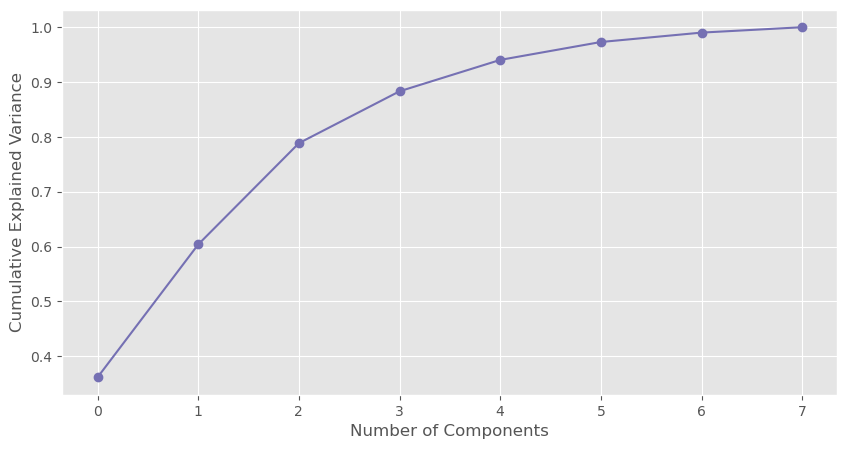

In [23]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

fig1 = plt.figure(figsize=(10,5))
plt.plot(range(0,len(cumulative_variance)),cumulative_variance, marker='o',linestyle='-',color=color_pal[2])
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

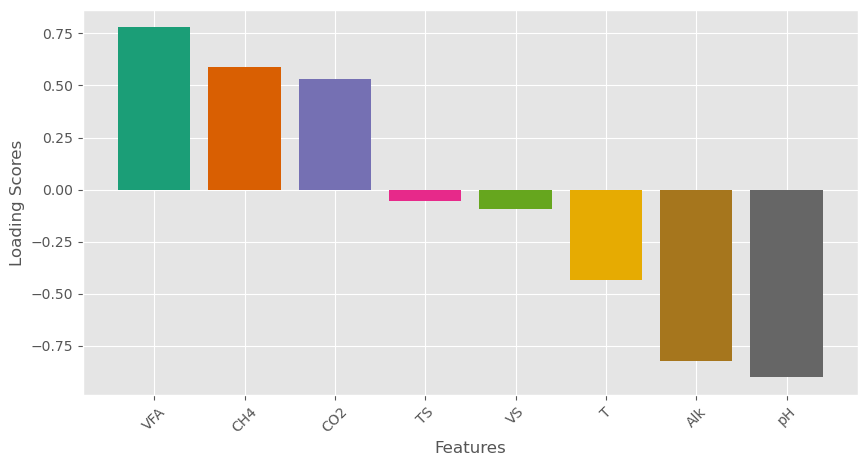

In [24]:
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
load_scores = loading[:,0]

# Sorting indices and feature names
sort_ind = np.argsort(load_scores)[::-1]
sort_load_scores = load_scores[sort_ind]
sort_names = [feature_names[x] for x in sort_ind]


# Create a bar plot for the loading scores of the first principal component
fig2 = plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_names)), sort_load_scores, tick_label=sort_names,color=color_pal)
plt.xlabel('Features')
plt.ylabel('Loading Scores')
plt.xticks(rotation=45) 
plt.show()

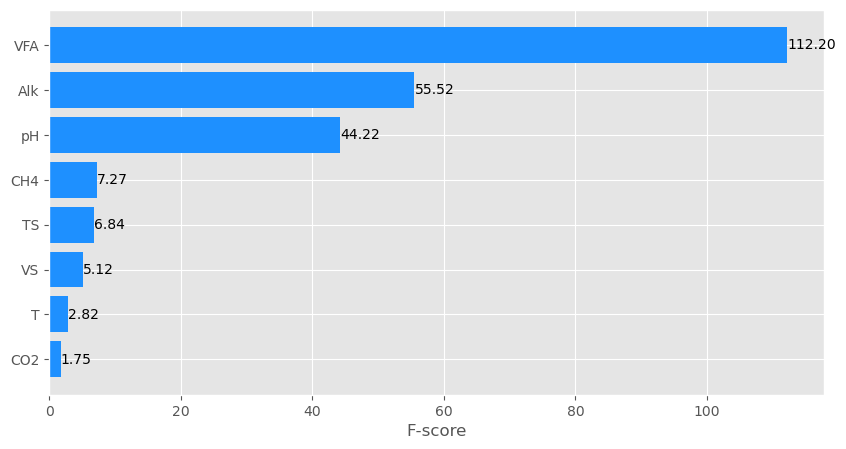

In [25]:
from sklearn.feature_selection import f_regression
# Calculate F-scores
F_scores, _ = f_regression(X_sc, y)

#sorted_indices = np.argsort(F_scores)
sorted_indices = np.argsort(F_scores)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_F_scores = F_scores[sorted_indices]

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(sorted_features)), sorted_F_scores, color='dodgerblue')
plt.yticks(np.arange(len(sorted_features)), sorted_features)
plt.xlabel('F-score')

# Labeling F-scores on the bars
for i, score in enumerate(sorted_F_scores):
    plt.text(score, i, '{:.2f}'.format(score), va='center', fontsize=10, color='black')
plt.gca().invert_yaxis()
plt.show()

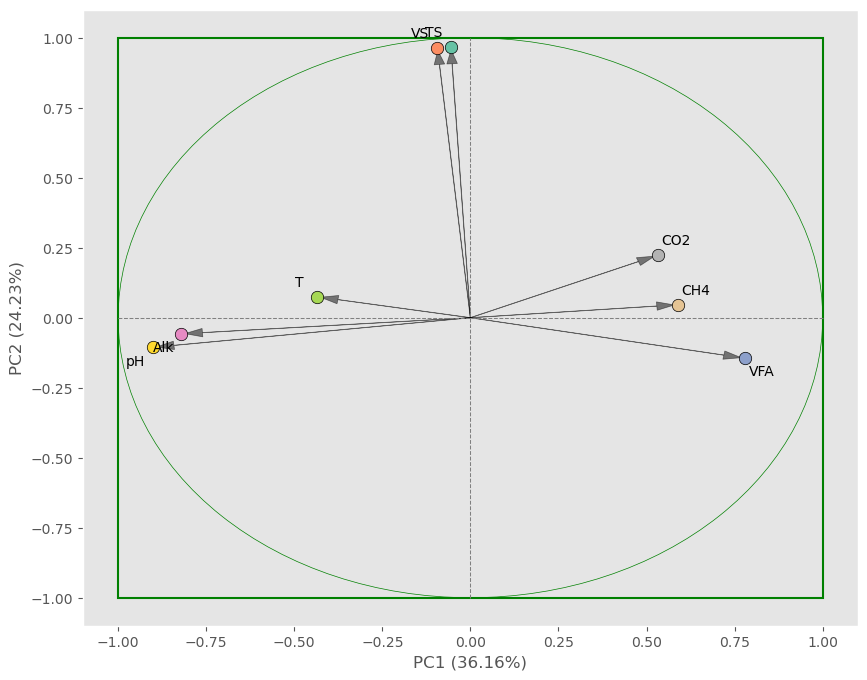

In [26]:
# Plot the variable factor map
palette = sns.color_palette("Set2", len(feature_names))

fig = plt.figure(figsize=(10, 8))

for i, (c1, c2) in enumerate(zip(loading[:,0], loading[:,1])):
    # Select color from the palette based on the index of feature
    color = palette[i % len(palette)]
     # Calculate arrow head coordinates
    arrow_length = 0.06  
    arrow_x = c1 - arrow_length * (c1/np.sqrt(c1**2 + c2**2))
    arrow_y = c2 - arrow_length * (c2/np.sqrt(c1**2 + c2**2))
    
    # Draw the arrow with pointer
    plt.arrow(0, 0, arrow_x, arrow_y, color="black", alpha=0.5, head_width=0.03, head_length=0.05)
    # Adjust the position of text labels based on the quadrant
    text_offset = 0.05  # Adjust this value as needed
    if c1 >= 0 and c2 >= 0:  # First quadrant
        text_x, text_y = c1 + text_offset, c2 + text_offset
    elif c1 < 0 and c2 >= 0:  # Second quadrant
        text_x, text_y = c1 - text_offset, c2 + text_offset
    elif c1 < 0 and c2 < 0:  # Third quadrant
        text_x, text_y = c1 - text_offset, c2 - text_offset
    else:  # Fourth quadrant
        text_x, text_y = c1 + text_offset, c2 - text_offset
    # Add text labels
    plt.scatter(c1, c2, color=color, marker='o', edgecolor='k', s=80)
    plt.text(text_x, text_y, feature_names[i], color='black', ha='center', va='center')


# Broken Line of the Coordinates
plt.hlines(0, -1, 1, linestyles='dashed', colors='gray',linewidth=0.75)
plt.vlines(0, -1, 1, linestyles='dashed', colors='gray',linewidth=0.75)


# Box and Circle Element
box_width = 2
box_height = 2
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='g')
box = plt.Rectangle((-1, -1), box_width, box_height, fill=False, edgecolor='g', linewidth=1.5)
plt.gca().add_patch(box)
plt.gca().add_artist(circle)



plt.xlim(-1.1, 1.1)  
plt.ylim(-1.1, 1.1)  
plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100, 2)))
plt.grid()
plt.show()


Data Pre-processing

1. Identify and Remove the Outlier

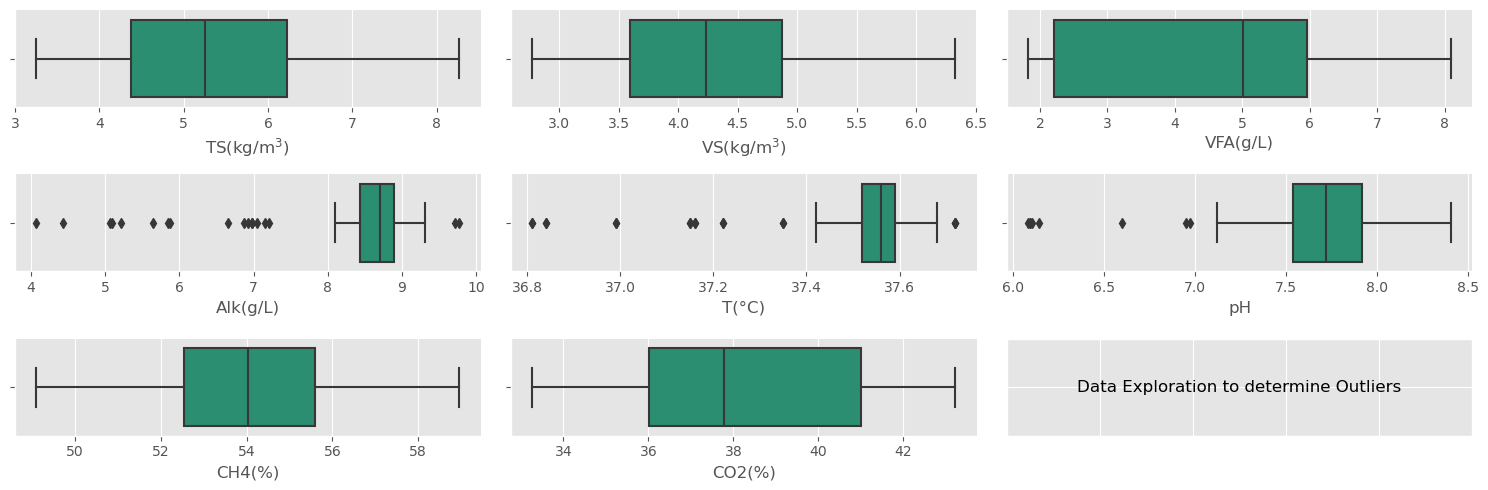

In [27]:
feat_df = df.drop(columns=['Biogas','Day'])
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5))

params = ["TS(kg/m$^3$)","VS(kg/m$^3$)","VFA(g/L)","Alk(g/L)","T(°C)","pH","CH4(%)","CO2(%)"]

# Plot boxplots for each feature
for i, col in enumerate(feat_df.columns):
    sns.boxplot(x=feat_df[col], ax=axes[i//3,i%3],palette=color_pal)
    sns.despine(ax=axes[i//3,i%3])  
    axes[i//3,i%3].set_xlabel(params[i])

# Add legend to the last block
axes[-1, -1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, \
    right=False, labelbottom=False, labelleft=False)
axes[-1, -1].text(0.5, 0.5, "Data Exploration to determine Outliers", horizontalalignment='center', \
    verticalalignment='center', fontsize=12, color='black', transform=axes[-1, -1].transAxes)


plt.tight_layout()
plt.show()

In [28]:
# IQR Method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = (df<lower_bound)|(df>upper_bound)
clean_df = df[~outliers.any(axis=1)]
clean_df.shape

(84, 10)

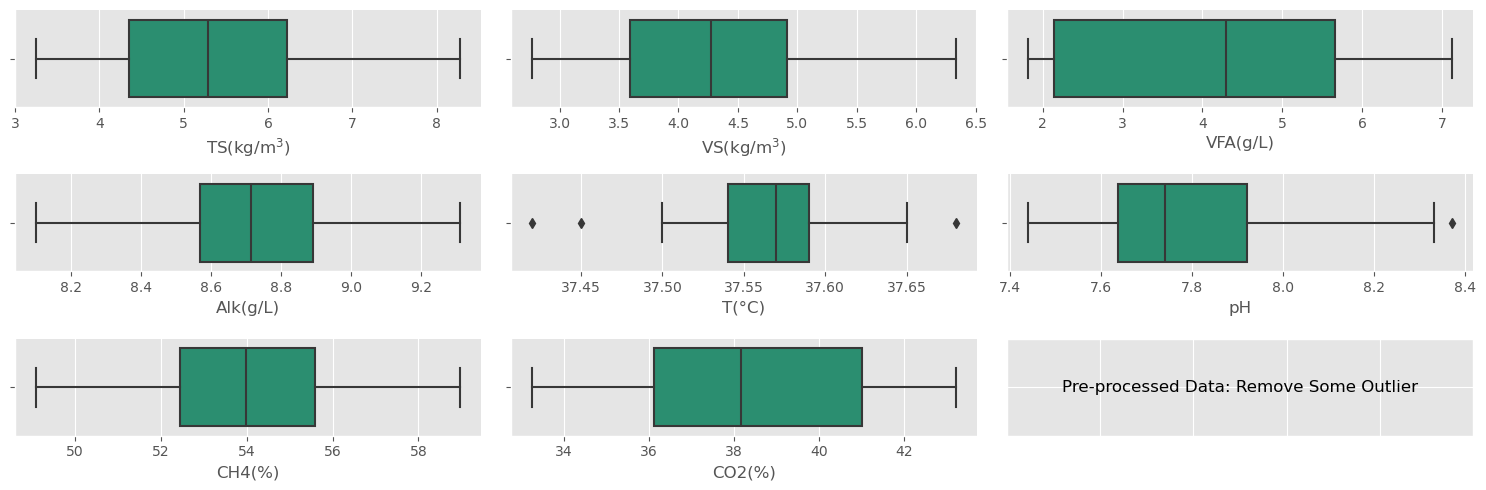

In [29]:
feat_df = clean_df.drop(columns=['Biogas','Day'])
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5))

params = ["TS(kg/m$^3$)","VS(kg/m$^3$)","VFA(g/L)","Alk(g/L)","T(°C)","pH","CH4(%)","CO2(%)"]

# Plot boxplots for each feature
for i, col in enumerate(feat_df.columns):
    sns.boxplot(x=feat_df[col], ax=axes[i//3,i%3],palette=color_pal)
    sns.despine(ax=axes[i//3,i%3])  
    axes[i//3,i%3].set_xlabel(params[i])

# Add legend to the last block
axes[-1, -1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, \
    right=False, labelbottom=False, labelleft=False)
axes[-1, -1].text(0.5, 0.5, "Pre-processed Data: Remove Some Outlier", horizontalalignment='center', \
    verticalalignment='center', fontsize=12, color='black', transform=axes[-1, -1].transAxes)

plt.tight_layout()
plt.show()

2. Fill Missing Value by the Mean

In [30]:
df_filled = clean_df.fillna(df.mean())
df_filled

,Day,TS,VS,VFA,Alk,T,pH,Biogas,CH4,CO2
17,64,4.570000,3.690000,7.120,8.890,37.57,7.80,9185.380000,53.01,38.77
18,80,4.950000,3.710000,6.950,8.930,37.54,7.46,7984.510000,54.20,38.47
19,92,4.490000,4.070000,6.350,8.740,37.65,7.65,8842.190000,54.66,39.87
20,95,4.540000,3.480000,6.250,8.890,37.59,7.87,8687.860000,50.64,36.92
21,100,5.350352,4.241389,6.530,8.690,37.68,7.68,12111.733619,49.59,36.33
...,...,...,...,...,...,...,...,...,...,...
105,350,7.481358,5.840000,1.900,8.213,37.54,7.80,14238.570000,50.11,38.18
106,352,4.751781,3.710000,1.850,8.413,37.59,7.80,19042.940000,49.31,37.08
107,354,5.581873,4.360000,1.950,8.113,37.60,7.74,20651.870000,50.77,36.12
108,356,6.137011,4.790000,1.932,8.313,37.65,7.83,20966.900000,50.79,38.46


In [53]:
df_filled.to_csv("clean_data.csv",index=False)

3. Train Dataset and Test Dataset Split

In [54]:
from sklearn.model_selection import train_test_split


# Feature and Response
X = df_filled.drop(columns=['Biogas','Day']).values
y = df_filled['Biogas'].values
feature_names = df2.columns.drop(['Biogas','Day']).tolist()

#Train Test Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

### Cross Validation of the Algorithms


In [58]:
# Cross Validation
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold


# ML Algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import  XGBRegressor


# Evaluation Metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score


### 1. K-Nearest Neighbor

In [70]:
kf = KFold(n_splits=10, shuffle=False)
eval_metrics = ['neg_mean_squared_error','neg_mean_absolute_error','r2']

# KNN Instance
knn = KNeighborsRegressor()

# K-Nearest Neighbor Metrics
knn_rmse = np.sqrt(-cross_val_score(knn,X_train,y_train,cv=kf, scoring=eval_metrics[0])).mean()
knn_mae = -cross_val_score(knn,X_train,y_train,cv=kf, scoring=eval_metrics[1]).mean()
knn_r2 = cross_val_score(knn,X_train,y_train,cv=kf, scoring=eval_metrics[2]).mean()


# Hypertuning Parameters
param_grid = {'n_neighbors': range(1,30), 'leaf_size': range(1,30)}


# Model Training
grid_search = GridSearchCV(knn, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)



GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': range(1, 30),
                         'n_neighbors': range(1, 30)},
             scoring='neg_mean_squared_error')

In [63]:
grid_search.best_estimator_

KNeighborsRegressor(leaf_size=1, n_neighbors=4)

In [75]:
print(f"RMSE: of KNN model: {knn_rmse}")
print (f"MAE of KNN model: {knn_mae}")
print(f"R2 of KNN model: {knn_r2}")

RMSE: of KNN model: 2701.9233285892597
MAE of KNN model: 2344.1932659410427
R2 of KNN model: 0.28932675738711555


### 2. Random Forest Cross Validation

In [82]:
# RF Instance
rf = RandomForestRegressor()

# Random Forest Metrics
rf_rmse = np.sqrt(-cross_val_score(rf,X_train,y_train,cv=kf, scoring=eval_metrics[0])).mean()
rf_mae = -cross_val_score(rf,X_train,y_train,cv=kf, scoring=eval_metrics[1]).mean()
rf_r2 = cross_val_score(rf,X_train,y_train,cv=kf, scoring=eval_metrics[2]).mean()

In [89]:
# Hypertuning Parameters
param_grid_rf = {'max_depth':range(1,10),'max_features':range(1,10),'n_estimators':range(20,30)}

# Model Training
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=kf, scoring='neg_mean_squared_error',n_jobs=16)
grid_search_rf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(), n_jobs=16,
             param_grid={'max_depth': range(1, 10),
                         'max_features': range(1, 10),
                         'n_estimators': range(20, 30)},
             scoring='neg_mean_squared_error')

In [90]:
grid_search_rf.best_estimator_

RandomForestRegressor(max_depth=8, max_features=5, n_estimators=21)

In [91]:
print(f"RMSE: of KNN model: {rf_rmse}")
print (f"MAE of KNN model: {rf_mae}")
print(f"R2 of KNN model: {rf_r2}")

RMSE: of KNN model: 2720.3737414947045
MAE of KNN model: 2216.6684306530606
R2 of KNN model: 0.20856110414632215


### 3. Support Vector Machine

In [95]:
# SVR Instance
svr = SVR(kernel='rbf',cache_size=4)

# SVR Metrics
svr_rmse = np.sqrt(-cross_val_score(svr, X_train,y_train, cv=kf, scoring=eval_metrics[0])).mean()
svr_mae = -cross_val_score(svr,X_train,y_train,cv=kf, scoring=eval_metrics[1]).mean()
svr_r2 = -cross_val_score(svr,X_train,y_train,cv=kf, scoring=eval_metrics[2]).mean()

# Hypertuning Parameters
param_grid_svr = {'gamma':[0.001,0.01,0.1,1],'C':[100,10**2,10**3,10**4],'epsilon':range(0,1)}

# Model Training
grid_search_svr = GridSearchCV(svr, param_grid_svr,cv=kf, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train,y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVR(cache_size=4),
             param_grid={'C': [100, 100, 1000, 10000], 'epsilon': range(0, 1),
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

In [96]:
grid_search_svr.best_estimator_

SVR(C=10000, cache_size=4, epsilon=0, gamma=0.1)

In [97]:
print(f"RMSE: of KNN model: {svr_rmse}")
print (f"MAE of KNN model: {svr_mae}")
print(f"R2 of KNN model: {svr_r2}")

RMSE: of KNN model: 3719.0040414107657
MAE of KNN model: 3163.360985754114
R2 of KNN model: 0.3094147670506538


### 4. Artificial Neural Network

In [ ]:
ann = MLPRegressor()

# Hypertuning Parameters
param_grid_ann = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization parameter
    'hidden_layer_sizes': [(0,5), (5,10), (10, 20), (20, 30)],  # Hidden layer sizes
    'activation': ['relu', 'logistic', 'tanh']  # Activation function
}
